<a href="https://colab.research.google.com/github/aishoo1612/HateAndAggressionDetection/blob/main/HAD_TCN_Modules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTING LIBRARIES AND SHIT


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import random
# from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import KFold

%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False
# nltk.download('twitter_samples')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  del sys.path[0]


In [2]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Hate And aggression Detection/agr_en_train.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Comments  12000 non-null  object
 1   level     12000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 187.6+ KB


In [6]:

df.groupby( by='level').count()

,Comments
level,
0,5052
1,4240
2,2708


In [7]:
comments, level = list(df.Comments), list(df.level)

In [8]:

comments[0]

'Well said sonu..you have courage to stand against dadagiri of Muslims'

# SECTION _ PREPROCESSING 
**Data Preprocessing**

In [9]:

# Define a function to compute the max length of sequence
def max_length(sequences):
    '''
    input:
        sequences: a 2D list of integer sequences
    output:
        max_length: the max length of the sequences
    '''
    max_length = 0
    for i, seq in enumerate(sequences):
        length = len(seq)
        if max_length < length:
            max_length = length
    return max_length

In [10]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"

print("Example of sentence: ", comments[4])

# Cleaning and Tokenization
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(comments)

# Turn the text into sequence
training_sequences = tokenizer.texts_to_sequences(comments)
max_len = max_length(training_sequences)

print('Into a sequence of int:', training_sequences[4])

# Pad the sequence to have the same size
training_padded = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
print('Into a padded sequence:', training_padded[4])

Example of sentence:  ??we r against cow slaughter,so of course it will stop leather manufacturing if it happens.
Into a sequence of int: [21, 79, 94, 232, 2250, 40, 5, 1276, 14, 19, 146, 5335, 2006, 38, 14, 784]
Into a padded sequence: [21 79 94 ...  0  0  0]


In [11]:
word_index = tokenizer.word_index
# See the first 10 words in the vocabulary
for i, word in enumerate(word_index):
    print(word, word_index.get(word))
    if i==9:
        break
vocab_size = len(word_index)+1
print(vocab_size)

<UNK> 1
the 2
to 3
and 4
of 5
is 6
in 7
a 8
for 9
are 10
23376


**Setting up the models**

In [12]:

from tensorflow.keras.utils import plot_model
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dropout, MaxPool1D, Flatten, Dense, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate

**CNN + BiGRU**

# THIS IS THE CNN + BiGRU SECTION

**DO NOT OVERRUN THEM. THEY TAKE OVER 5 HRS TO TRAIN >.<**

In [24]:
def define_model(filters = 50, kernel_size = 3, activation='relu', input_dim = None, output_dim=300, max_length = None ):
  
    # Channel 1
    input1 = Input(shape=(max_length,))
    embeddding1 = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_length)(input1)
    conv1 = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', 
                   kernel_constraint= MaxNorm( max_value=3, axis=[0,1]))(embeddding1)
    pool1 = MaxPool1D(pool_size=2, strides=2)(conv1)
    flat1 = Flatten()(pool1)
    drop1 = Dropout(0.5)(flat1)
    dense1 = Dense(10, activation='relu')(drop1)
    drop1 = Dropout(0.5)(dense1)
    out1 = Dense(1, activation='sigmoid')(drop1)
    
    # Channel 2
    input2 = Input(shape=(max_length,))
    embeddding2 = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_length, mask_zero=True)(input2)
    gru2 = Bidirectional(GRU(64))(embeddding2)
    drop2 = Dropout(0.5)(gru2)
    out2 = Dense(1, activation='sigmoid')(drop2)
    
    # Merge
    merged = concatenate([out1, out2])
    
    # Interpretation
    outputs = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[input1, input2], outputs=outputs)
    
    # Compile
    model.compile( loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [25]:

model_0 = define_model( input_dim=1000, max_length=100)
model_0.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 300)     300000      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 98, 50)       45050       embedding[0][0]                  
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 49, 50)       0           conv1d[0][0]                     
______________________________________________________________________________________________

In [28]:

class myCallback(tf.keras.callbacks.Callback):
    # Overide the method on_epoch_end() for our benefit
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.5):
            print("\nReached 52% accuracy so cancelling training!")
            self.model.stop_training=True


callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, 
                                             patience=7, verbose=2, 
                                             mode='auto', restore_best_weights=True)

In [ ]:
# Parameter Initialization
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"
activations = ['relu']
filters = 100
kernel_sizes = [1, 2, 3, 4, 5, 6]

columns = ['Activation', 'Filters', 'acc1', 'acc2', 'acc3', 'acc4', 'acc5', 'acc6', 'acc7', 'acc8', 'acc9', 'acc10', 'AVG']
record = pd.DataFrame(columns = columns)

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
comments, level = list(df.Comments), list(df.level)

for activation in activations:
    for kernel_size in kernel_sizes:
        # kfold.split() will return set indices for each split
        acc_list = []
        for train, test in kfold.split(comments):
            
            train_x, test_x = [], []
            train_y, test_y = [], []
            
            for i in train:
                train_x.append(comments[i])
                train_y.append(level[i])

            for i in test:
                test_x.append(comments[i])
                test_y.append(level[i])

            # Turn the labels into a numpy array
            train_y = np.array(train_y)
            test_y = np.array(test_y)

            # encode data using
            # Cleaning and Tokenization
            tokenizer = Tokenizer(oov_token=oov_tok)
            tokenizer.fit_on_texts(train_x)

            # Turn the text into sequence
            training_sequences = tokenizer.texts_to_sequences(train_x)
            test_sequences = tokenizer.texts_to_sequences(test_x)

            max_len = max_length(training_sequences)

            # Pad the sequence to have the same size
            Xtrain = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
            Xtest = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

            word_index = tokenizer.word_index
            vocab_size = len(word_index)+1
            
            # Define the input shape
            model = define_model(filters, kernel_size, activation, input_dim=vocab_size, max_length=max_len)

            # Train the model and initialize test accuracy with 0
            acc = 0
            while(acc<0.5):
                
                # Train the model
                model.fit(x=[Xtrain, Xtrain], y = train_y, batch_size=50, epochs=100, verbose=1, 
                          callbacks=[callbacks], validation_data=([Xtest, Xtest], test_y))

                # evaluate the model
                loss, acc = model.evaluate([Xtest, Xtest], test_y, verbose=0)
                print('Test Accuracy: {}'.format(acc*100))
                
                if (acc<0.5):
                    print('The model suffered from local minimum. Retrain the model!')
                    model = define_model(filters, kernel_size, activation, input_dim=vocab_size, max_length=max_len)
                    
                else:
                    print('Done!')

            # evaluate the model
            loss, acc = model.evaluate([Xtest, Xtest], test_y, verbose=0)
            print('Test Accuracy: {}'.format(acc*100))

            acc_list.append(acc*100)
            
        mean_acc = np.array(acc_list).mean()
        parameters = [activation, kernel_size]
        entries = parameters + acc_list + [mean_acc]

        temp = pd.DataFrame([entries], columns=columns)
        record = record.append(temp, ignore_index=True)
        print()
        print(record)
        print()

Test Accuracy: 37.583333253860474
The model suffered from local minimum. Retrain the model!


KeyboardInterrupt: ignored

In [ ]:

record.sort_values(by='AVG', ascending=False)

,Activation,Filters,acc1,acc2,acc3,acc4,acc5,acc6,acc7,acc8,acc9,acc10,AVG
0,relu,1,54.083335,51.499999,51.583332,51.583332,54.833335,53.666669,53.666669,51.583332,51.833332,51.166666,52.55
1,relu,2,53.250003,51.416665,52.666664,51.333332,53.166670,54.583335,52.333331,52.833331,50.749999,53.166670,52.55


In [ ]:
record[['Activation', 'AVG']].groupby(by='Activation').max().sort_values(by='AVG', ascending=False)

,AVG
Activation,
relu,52.55


In [ ]:
report = record.sort_values(by='AVG', ascending=False)
report = report.to_excel('HYBRID_CR.xlsx', sheet_name='random')

**tcn**

# Temporal Convolutional Networks Below
**DO NOT OVER RUN THEM. THEY TAKE OVER 4.5 HRS TO TRAIN**



In [ ]:
!pip install keras-tcn


     |████████████████████████████████| 1.1 MB 8.8 MB/s 


In [ ]:
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model

def define_model(kernel_size = 3, activation='relu', input_dim = None, output_dim=300, max_length = None ):
    
    inp = Input( shape=(max_length,))
    x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_length)(inp)
    x = SpatialDropout1D(0.1)(x)
    
    x = TCN(128,dilations = [1, 2, 4], return_sequences=True, activation = activation, name = 'tcn1')(x)
    x = TCN(64,dilations = [1, 2, 4], return_sequences=True, activation = activation, name = 'tcn2')(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(16, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)    

    model = Model(inputs=inp, outputs=outp)
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model


In [ ]:
model_0 = define_model( input_dim=1000, max_length=100)
model_0.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 300)     300000      input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 100, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
tcn1 (TCN)                      (None, 100, 128)     400256      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [ ]:

callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, 
                                             patience=10, verbose=2, 
                                             mode='auto', restore_best_weights=True)

In [ ]:
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"
activations = ['relu', 'tanh']
kernel_sizes = [1, 2, 3 , 4 , 5 , 6]

columns = ['Activation', 'Filters', 'acc1', 'acc2', 'acc3', 'acc4', 'acc5', 'acc6', 'acc7', 'acc8', 'acc9', 'acc10', 'AVG']
record = pd.DataFrame(columns = columns)

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(10, True)

# Separate the sentences and the labels
comments, level = list(df.Comments), list(df.level)

exp = 0

for activation in activations:
    for kernel_size in kernel_sizes:
        # kfold.split() will return set indices for each split
        exp+=1
        print('-------------------------------------------')
        print('Training {}: {} activation, {} kernel size.'.format(exp, activation, kernel_size))
        print('-------------------------------------------')
        acc_list = []
        for train, test in kfold.split(comments):
            
            train_x, test_x = [], []
            train_y, test_y = [], []
            
            for i in train:
                train_x.append(comments[i])
                train_y.append(level[i])

            for i in test:
                test_x.append(comments[i])
                test_y.append(level[i])

            # Turn the labels into a numpy array
            train_y = np.array(train_y)
            test_y = np.array(test_y)

            # encode data using
            # Cleaning and Tokenization
            tokenizer = Tokenizer(oov_token=oov_tok)
            tokenizer.fit_on_texts(train_x)

            # Turn the text into sequence
            training_sequences = tokenizer.texts_to_sequences(train_x)
            test_sequences = tokenizer.texts_to_sequences(test_x)

            max_len = max_length(training_sequences)

            # Pad the sequence to have the same size
            Xtrain = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
            Xtest = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

            word_index = tokenizer.word_index
            vocab_size = len(word_index)+1

            # Define the input shape
            model = define_model(kernel_size, activation, input_dim=vocab_size, max_length=max_len)

            # Train the model
            model.fit(Xtrain, train_y, batch_size=50, epochs=100, verbose=2, 
                      callbacks=[callbacks], validation_data=(Xtest, test_y))

            # evaluate the model
            loss, acc = model.evaluate(Xtest, test_y, verbose=0)
            print('Test Accuracy: {}'.format(acc*100))

            acc_list.append(acc*100)
            
        mean_acc = np.array(acc_list).mean()
        parameters = [activation, kernel_size]
        entries = parameters + acc_list + [mean_acc]

        temp = pd.DataFrame([entries], columns=columns)
        record = record.append(temp, ignore_index=True)
        print()
        print(record)
        print()

-------------------------------------------
Training 1: relu activation, 1 kernel size.
-------------------------------------------
Epoch 1/100
216/216 - 53s - loss: -4.3817e+13 - accuracy: 0.3940 - val_loss: -2.6234e+15 - val_accuracy: 0.4667
Epoch 2/100
216/216 - 19s - loss: nan - accuracy: 0.4350 - val_loss: nan - val_accuracy: 0.4175
Epoch 3/100
216/216 - 19s - loss: nan - accuracy: 0.4214 - val_loss: nan - val_accuracy: 0.4175
Epoch 4/100
216/216 - 19s - loss: nan - accuracy: 0.4214 - val_loss: nan - val_accuracy: 0.4175
Epoch 5/100
216/216 - 20s - loss: nan - accuracy: 0.4214 - val_loss: nan - val_accuracy: 0.4175
Epoch 6/100
216/216 - 20s - loss: nan - accuracy: 0.4214 - val_loss: nan - val_accuracy: 0.4175
Epoch 7/100
216/216 - 20s - loss: nan - accuracy: 0.4214 - val_loss: nan - val_accuracy: 0.4175
Epoch 8/100
216/216 - 20s - loss: nan - accuracy: 0.4214 - val_loss: nan - val_accuracy: 0.4175
Epoch 9/100
216/216 - 20s - loss: nan - accuracy: 0.4214 - val_loss: nan - val_accur

In [ ]:
record.sort_values(by='AVG', ascending=False)
record[['Activation', 'AVG']].groupby(by='Activation').max().sort_values(by='AVG', ascending=False)

In [ ]:
report = record.sort_values(by='AVG', ascending=False)
report = report.to_excel('TCN_CR.xlsx', sheet_name='random')

**With Upsampling of One Class**

In [13]:
df.groupby(by = 'level').count()

,Comments
level,
0,5052
1,4240
2,2708


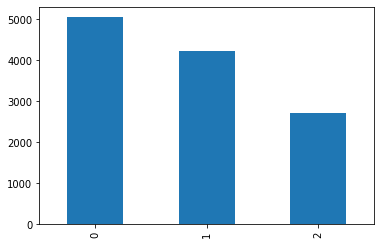

In [14]:

df['level'].value_counts().plot.bar()

Since, the gap is visible I've tried Up Sampling 2 to have a more distributed model using SMOTE Technique so as to not overfit the model

**IT HASN"T BEEN RUN YET**

In [ ]:
/*from sklearn.model_selection import train_test_split
X = comments
y = level
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)*/

# THIS IS SMOTE SECTION

**The code is below, derieved from SMOTE PAPER however hasn't been implemented yet**

In [21]:
def resamplingDataPrep(X_train, y_train, y_test): 
    # concatenate our training data back together
    resampling = X_train.copy()
    resampling[y_test] = y_train.values
    # separate minority and majority classes
    majority_class = resampling[resampling[y_test]==0]
    minority_class = resampling[resampling[y_test]==1]
    # Get a class count to understand the class imbalance.
    print('majority_class: '+ str(len(majority_class)))
    print('minority_class: '+ str(len(minority_class)))
    return majority_class, minority_class


In [23]:
def upsample_SMOTE(X_train, y_train, ratio=1.0):
    """Upsamples minority class using SMOTE.
    Ratio argument is the percentage of the upsampled minority class in relation
    to the majority class. Default is 1.0
    """
    sm = SMOTE(random_state=23, sampling_strategy=ratio)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    print(len(X_train_sm), len(y_train_sm))
    return X_train_sm, y_train_sm
print('Cool')

Cool
